# Power loss from VAE latent space model
We use the parameterized crack electroluminescense (EL) images resulting from the VAE to correlate with power loss
- This uses the 3CH-VAE, where MultiSolSegment is used to extract the crack, dark and busbar layer. All of these layers are used to train the 3CH-VAE
- The lantent vectors together with the previously processed IV curves are loaded in
- An XGBoost model is trained to predict the power loss and open circuit voltage (Voc) loss for these cells

The EL and IV pairs will be made available at a later point, they are provided by our collaborators from Technical University of Denmark (DTU).

## Imports

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import pickle
import optuna

#xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from supertree import SuperTree

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


## Pearson

In [15]:
df_space = pd.read_pickle("DTU3CHspace_IV.pickle")

In [16]:
df_space.columns

Index(['I', 'V', 'pmpp', 'Module_ID', 'Cell_ID', 'ELPath', 'IRaw', 'VRaw',
       'Voc', 'Iph', 'I0', 'Rs', 'Rsh', 'nNsVth', 'pmpp_diff', 'pmpp_diff_%',
       'Voc_diff', 'nNsVth_diff', 'Rs_diff', 'Rsh_diff', 'I0_diff',
       'Voc_diff_%', 'lat_vec'],
      dtype='object')

In [17]:
df_space[0:5].lat_vec.value

0      [0.24241999, 0.45217514, 0.97815484, 1.4499949...
1      [1.1702411, -1.2032634, -1.1532567, 1.283272, ...
2      [-1.2923387, 0.8474884, 2.662438, 0.7604594, -...
3      [0.21270931, -0.47887728, -1.3520491, 1.231100...
4      [-0.74178386, -0.28830415, -0.08164142, -0.243...
                             ...                        
315    [0.18980509, -0.7921633, -0.24548268, -0.21012...
317    [0.589571, 0.8981719, 1.0020573, -0.28720015, ...
318    [0.19169639, -0.8840204, -0.02412197, -0.01577...
320    [1.6088381, -1.6837691, -1.8621643, -0.2348454...
325    [-1.1362677, -0.51101047, -0.34467927, -0.0648...
Name: lat_vec, Length: 309, dtype: object

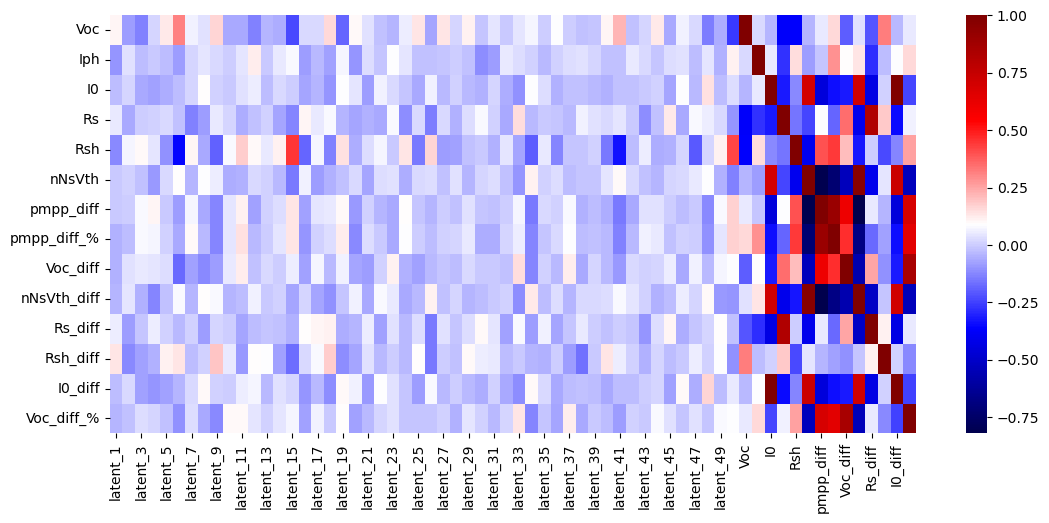

In [6]:
#pearson DTU
variables_to_correlate = ['Voc', 'Iph', 'I0', 'Rs', 'Rsh', 'nNsVth', 'pmpp_diff','pmpp_diff_%',
       'Voc_diff', 'nNsVth_diff', 'Rs_diff', 'Rsh_diff', 'I0_diff',
       'Voc_diff_%', 'lat_vec']

# Extract the latent space vectors into a DataFrame (assuming lat_vec is a list of vectors)
latent_space_df = pd.DataFrame(df_space['lat_vec'].tolist(), 
                               columns=[f'latent_{i+1}' for i 
                                        in range(len(df_space['lat_vec'].iloc[0]))])

# Combine the latent space with the other variables of interest
correlation_df = pd.concat([latent_space_df, df_space[variables_to_correlate]], axis=1)
correlation_df = correlation_df.drop(['lat_vec'], axis=1)

# Calculate the Pearson correlation matrix
correlation_matrix = correlation_df.corr()

# Visualize the correlation matrix as a heatmap
fig = plt.figure(figsize=(52/4, 38/7))
sns.heatmap(correlation_matrix.iloc[50:,:], annot=False, cmap='seismic', fmt='.2f') #coolwarm

# plt.suptitle('Pearson Correlation between Latent Space and Selected Variables')
plt.show()

The pearson plot shows us that we do have certain correlations between the latent vector components and variables such as pmpp_diff, Voc_diff and Rsh

## XGBoost model

In [10]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']


Training XGBoost model for pmpp_diff_%...
Training Features Shape: (61, 50)
Testing Features Shape: (16, 50)
Training Targets Shape: (61, 3)
Testing Targets Shape: (16, 3)
Model for pmpp_diff_% saved as xgb_model_pmpp_diff_percent_3CH.pkl

Metrics for pmpp_diff_% (Test Data):
R squared (Test): 0.69

Metrics for pmpp_diff_% (All Data):
R squared (All): 0.94

Training XGBoost model for Rsh...
Training Features Shape: (61, 50)
Testing Features Shape: (16, 50)
Training Targets Shape: (61, 3)
Testing Targets Shape: (16, 3)
Model for Rsh saved as xgb_model_Rsh_3CH.pkl

Metrics for Rsh (Test Data):
R squared (Test): 0.44

Metrics for Rsh (All Data):
R squared (All): 0.93

Training XGBoost model for Voc_diff_%...
Training Features Shape: (61, 50)
Testing Features Shape: (16, 50)
Training Targets Shape: (61, 3)
Testing Targets Shape: (16, 3)
Model for Voc_diff_% saved as xgb_model_Voc_diff_percent_3CH.pkl

Metrics for Voc_diff_% (Test Data):
R squared (Test): 0.39

Metrics for Voc_diff_% (All 

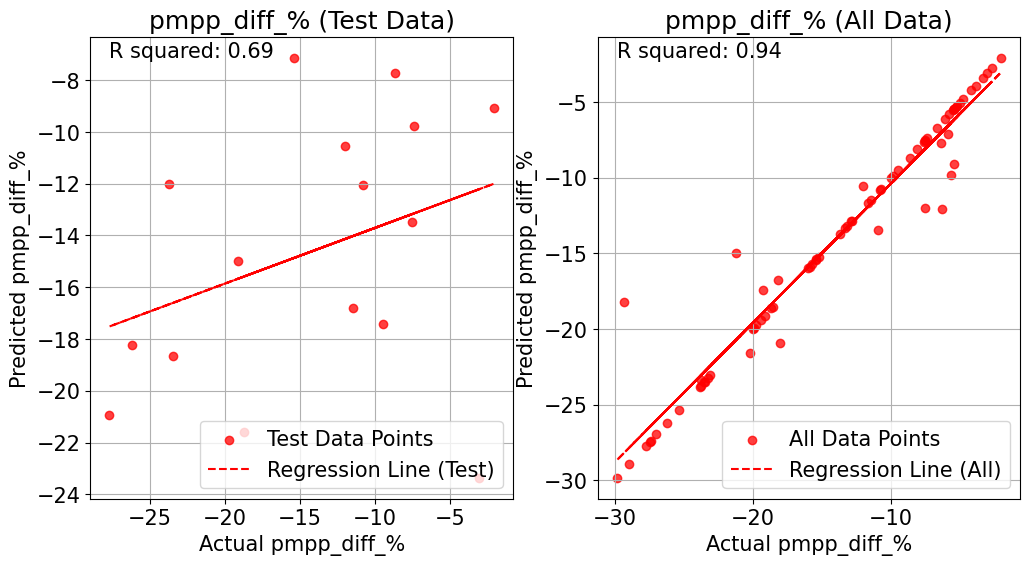

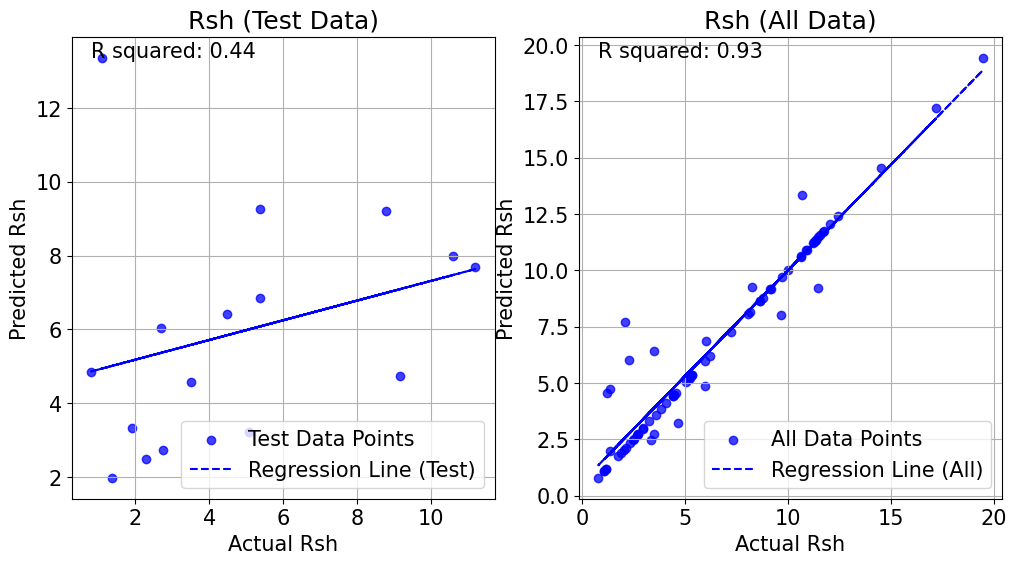

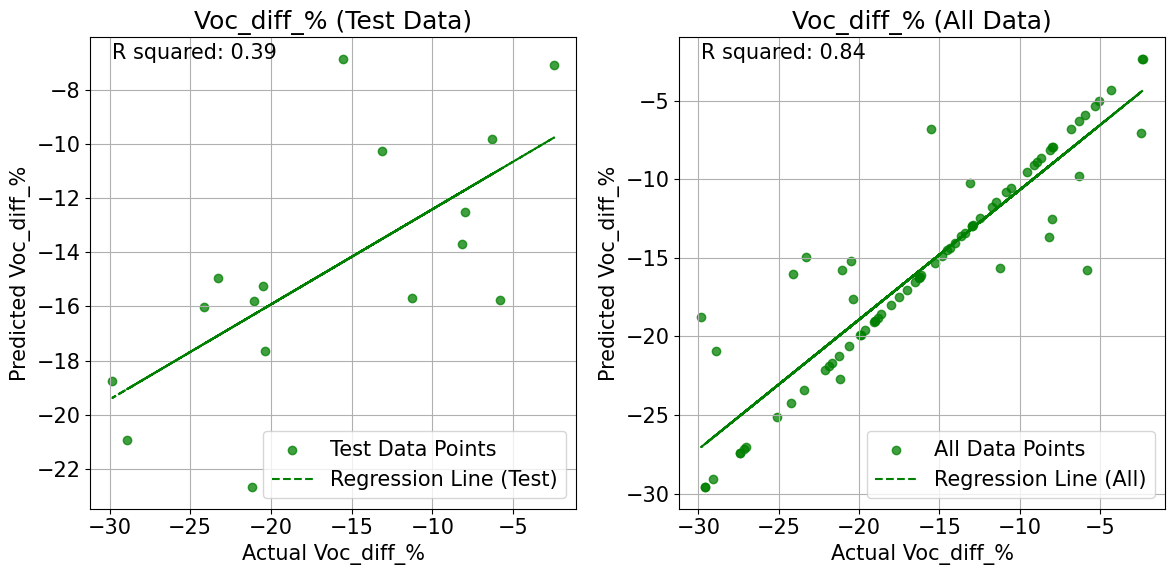

In [13]:
#Doing some more datacleaning to try and increase results
plt.rcParams.update({'font.size': 15})
# Prepare the data
df_nonan = df_space.dropna(subset=['pmpp_diff_%', 'Rsh', 'Voc_diff_%'])

df_cleaned = df_nonan[(df_nonan['pmpp_diff_%'] >= -30) & (df_nonan['pmpp_diff_%'] <= -2) & 
                       (df_nonan['Voc_diff_%'] >= -30) & (df_nonan['Voc_diff_%'] <= -2)]
df_nonan = df_cleaned

x = np.vstack(df_nonan['lat_vec'].values)
y = df_nonan[['pmpp_diff_%', 'Rsh', 'Voc_diff_%']].values

#XGBoost parameters, optimized with optuna
best_params_pmpp = {'test_size': 0.1995055008750887, 'random_state': 40, 'n_estimators': 39, 'learning_rate': 0.31558368730337655, 'max_depth': 4}
best_params_voc = {'test_size': 0.1991991513579253, 'random_state': 89, 'n_estimators': 77, 'learning_rate': 0.21971151319014506, 'max_depth': 6}

# Initialize lists to store models and predictions
xgb_models = []
y_pred_xgb_test = []
y_pred_xgb_all = []
R_sq_test = []
R_sq_all = []

# Train XGBoost models for each target variable
for i, target in enumerate(['pmpp_diff_%', 'Rsh', 'Voc_diff_%']):
    print(f"\nTraining XGBoost model for {target}...")
    
    # Select best parameters based on the target
    if target == 'pmpp_diff_%':
        best_params = best_params_pmpp
    elif target == 'Rsh':
        best_params = best_params_pmpp  
    else:
        best_params = best_params_voc

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=best_params['random_state']
    )
    
    print(f'Training Features Shape: {x_train.shape}')
    print(f'Testing Features Shape: {x_test.shape}')
    print(f'Training Targets Shape: {y_train.shape}')
    print(f'Testing Targets Shape: {y_test.shape}')
    
    # Initialize and train the XGBoost model
    xgb = XGBRegressor(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        random_state=best_params['random_state']
    )
    xgb.fit(x_train, y_train[:, i])
    xgb_models.append(xgb)
    
    # Save the model to a file
    model_filename = f"xgb_model_{target.replace('%', 'percent')}_3CH.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(xgb, f)
    print(f"Model for {target} saved as {model_filename}")
    
    # Predict on the test set
    y_pred_test = xgb.predict(x_test)
    y_pred_xgb_test.append(y_pred_test)
    
    # Predict on the entire dataset
    y_pred_all = xgb.predict(x)
    y_pred_xgb_all.append(y_pred_all)
    
    # Calculate metrics for the test set
    r_squared_test = r2_score(y_test[:, i], y_pred_test)
    R_sq_test.append(r_squared_test)
    
    # Calculate metrics for the entire dataset
    r_squared_all = r2_score(y[:, i], y_pred_all)
    R_sq_all.append(r_squared_all)
    
    print(f"\nMetrics for {target} (Test Data):")
    print(f'R squared (Test): {r_squared_test:.2f}')
    
    print(f"\nMetrics for {target} (All Data):")
    print(f'R squared (All): {r_squared_all:.2f}')

# Visualize predictions for each target variable
colors = ['red', 'blue', 'green']  # Colors for the plots
for i, target in enumerate(['pmpp_diff_%', 'Rsh', 'Voc_diff_%']):
    plt.figure(figsize=(12, 6))
    
    # Plot for test data
    plt.subplot(1, 2, 1)
    plt.scatter(y_test[:, i], y_pred_xgb_test[i], color=colors[i], alpha=0.75, label='Test Data Points')
    z_test = np.polyfit(y_test[:, i], y_pred_xgb_test[i], 1)  # Fit a linear regression line
    p_test = np.poly1d(z_test)
    plt.plot(y_test[:, i], p_test(y_test[:, i]), color=colors[i], linestyle='--', label='Regression Line (Test)')
    plt.title(f'{target} (Test Data)')
    plt.text(min(y_test[:, i]), max(y_pred_xgb_test[i]), f'R squared: {R_sq_test[i]:.2f}')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.legend(loc="lower right")
    plt.grid(True)

    
    # Plot for all data
    plt.subplot(1, 2, 2)
    plt.scatter(y[:, i], y_pred_xgb_all[i], color=colors[i], alpha=0.75, label='All Data Points')
    z_all = np.polyfit(y[:, i], y_pred_xgb_all[i], 1)  # Fit a linear regression line
    p_all = np.poly1d(z_all)
    plt.plot(y[:, i], p_all(y[:, i]), color=colors[i], linestyle='--', label='Regression Line (All)')
    plt.title(f'{target} (All Data)')
    plt.text(min(y[:, i]), max(y_pred_xgb_all[i]), f'R squared: {R_sq_all[i]:.2f}')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f"xgboost_{target[:-1]}.png", dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

## Visualization of the decision tree

In [8]:
# Define feature names and target names
feature_names = [f"Feature_{i}" for i in range(x_train.shape[1])]  
target_names = ["pmpp_diff_%", "Rsh", "Voc_diff_%"]  

# Initialize SuperTree
st = SuperTree(
    xgb_models[0],  # Use the trained XGBRegressor model for pmpp_diff_%
    x_train,  # Training features
    y_train[:, 0],  # Training target for pmpp_diff_%
    feature_names,  # Feature names
    target_names  # Target names
)

# Visualize the tree
st.show_tree(which_tree=1)  # Visualize the second tree (change index for other trees)

# Save to HTML
st.save_html("tree_visualization_3CH.html")  # Hypothetical parameter for higher resolution

HTML saved to tree_visualization_3CH.html


## Optuna for XGBoost parameters
Short demonstration on how to use the optuna python package to tune the xgboost parameters

In [ ]:
#Optuna to optimize xgboost parameters Pmpp
optuna.logging.set_verbosity(optuna.logging.FATAL)


# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    test_size = trial.suggest_float("test_size", 0.199, 0.2001)  # Range for test size
    random_state = trial.suggest_int("random_state", 0, 100)  # Random state
    n_estimators = trial.suggest_int("n_estimators", 10, 100)  # Number of trees
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5)  # Learning rate
    max_depth = trial.suggest_int("max_depth", 2, 10)  # Maximum depth of trees

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    # Train the XGBoost model for the pmpp_diff_% case
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state
    )
    xgb.fit(x_train, y_train[:, 0])  # Train on the pmpp_diff_% target

    # Predict on the test set
    y_pred = xgb.predict(x_test)

    # Calculate R-squared
    r_squared = r2_score(y_test[:, 0], y_pred)
    mse = mean_squared_error(y_test[:, 0], y_pred)
    
    # print(f"Completed trial {len(study.trials)}")

    return mse  # Optuna will maximize this value

# Create an Optuna study to optimize the hyperparameters
study = optuna.create_study(direction="minimize")  # Maximize R-squared
study.optimize(objective, n_trials=10000)  # Perform 50 trials

# Print the best hyperparameters
print("\nBest hyperparameters:")
print(study.best_params)
print(f"mse: {study.best_trial.values[0]}")

# Train the final model using the best hyperparameters
best_params = study.best_params
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=best_params["test_size"], random_state=best_params["random_state"])

xgb_final = XGBRegressor(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    random_state=best_params["random_state"]
)
xgb_final.fit(x_train, y_train[:, 0])

# Predict on the test set
y_pred_final = xgb_final.predict(x_test)

# Calculate metrics
r_squared_final = r2_score(y_test[:, 0], y_pred_final)
print(f"\nFinal R squared: {r_squared_final:.2f}")

# Visualize predictions
plt.figure()
plt.scatter(y_test[:, 0], y_pred_final, color='red', alpha=0.75, label='Data Points')

# Add regression line
z = np.polyfit(y_test[:, 0], y_pred_final, 1)  # Fit a linear regression line
p = np.poly1d(z)
plt.plot(y_test[:, 0], p(y_test[:, 0]), color='red', linestyle='--', label='Regression Line')

plt.title('pmpp_diff_%')
plt.text(min(y_test[:, 0]), max(y_pred_final), f'R squared: {r_squared_final:.2f}')
plt.xlabel('Actual pmpp_diff_%')
plt.ylabel('Predicted pmpp_diff_%')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Optuna to optimize xgboost parameters Voc
import optuna
optuna.logging.set_verbosity(optuna.logging.FATAL)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    test_size = trial.suggest_float("test_size", 0.199, 0.2001)  # Range for test size
    random_state = trial.suggest_int("random_state", 0, 100)  # Random state
    n_estimators = trial.suggest_int("n_estimators", 10, 100)  # Number of trees
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5)  # Learning rate
    max_depth = trial.suggest_int("max_depth", 2, 10)  # Maximum depth of trees

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    # Train the XGBoost model for the pmpp_diff_% case
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state
    )
    xgb.fit(x_train, y_train[:, 2])  # Train on the Voc_diff_%'target

    # Predict on the test set
    y_pred = xgb.predict(x_test)

    # Calculate R-squared
    r_squared = r2_score(y_test[:, 2], y_pred)
    mse = mean_squared_error(y_test[:, 0], y_pred)
    
    # print(f"Completed trial {len(study.trials)}")

    return mse  # Optuna will maximize this value

# Create an Optuna study to optimize the hyperparameters
study = optuna.create_study(direction="minimize") 
study.optimize(objective, n_trials=10000)  # Perform 50 trials

# Print the best hyperparameters
print("\nBest hyperparameters:")
print(study.best_params)
print(f"mse: {study.best_trial.values[0]}")

# Train the final model using the best hyperparameters
best_params = study.best_params
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=best_params["test_size"], random_state=best_params["random_state"])

xgb_final = XGBRegressor(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    random_state=best_params["random_state"]
)
xgb_final.fit(x_train, y_train[:, 0])

# Predict on the test set
y_pred_final = xgb_final.predict(x_test)

# Calculate metrics
r_squared_final = r2_score(y_test[:, 0], y_pred_final)
print(f"\nFinal R squared: {r_squared_final:.2f}")

# Visualize predictions
plt.figure()
plt.scatter(y_test[:, 0], y_pred_final, color='red', alpha=0.75, label='Data Points')

# Add regression line
z = np.polyfit(y_test[:, 0], y_pred_final, 1)  # Fit a linear regression line
p = np.poly1d(z)
plt.plot(y_test[:, 0], p(y_test[:, 0]), color='green', linestyle='--', label='Regression Line')

plt.title('pmpp_diff_%')
plt.text(min(y_test[:, 0]), max(y_pred_final), f'R squared: {r_squared_final:.2f}')
plt.xlabel('Actual pmpp_diff_%')
plt.ylabel('Predicted pmpp_diff_%')
plt.legend()
plt.grid(True)
plt.show()